In [1]:
import numpy as np
import geopandas as gpd
from geopandas.tools import sjoin
from matplotlib import pyplot as plt
import pandas as pd
from shapely.geometry import Point
import os

# folium for maps
import folium
from folium import plugins

# geopandas for operations on shape files
import geopandas as gpd
from shapely.geometry import Polygon
from pprint import pprint 

# plotly for other visuals
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
pd.options.display.max_columns = 999

In [4]:
dept_of_interest = "Dept_37-00027"
dept_folder = str("/Users/apple/Downloads/data-science-for-good-2/" + dept_of_interest + "/")
os.listdir(dept_folder)
k,census_data_folder,police_csv,police_shp_folder = os.listdir(dept_folder)


In [5]:
for file in os.listdir(dept_folder+police_shp_folder):
    if ".shp" in file:
        shp_file = file
police_shp_gdf = gpd.read_file(dept_folder+police_shp_folder+'/'+shp_file)

# Use Pandas to read the "prepped" CSV, dropping the first row, which is just more headers
police_arrest_df = pd.read_csv(dept_folder+police_csv).iloc[1:].reset_index(drop=True)

/Users/apple/Downloads/data-science-for-good-2/Dept_37-00027/37-00027_Shapefiles/APD_DIST.shp


In [80]:
latlon_exists_index = police_arrest_df[['LOCATION_LATITUDE','LOCATION_LONGITUDE']].dropna().index

# Only use subset of data with existing Lat and Lon, to avoid Geocoding addresses or
# "guessing" at the meaning of Y_COORDINATE and Y_COORDINATE.1
police_arrest_df = police_arrest_df.iloc[latlon_exists_index].reset_index(drop=True)
police_arrest_df['LOCATION_LATITUDE'] = (police_arrest_df['LOCATION_LATITUDE']
                                         .astype('float'))
police_arrest_df['LOCATION_LONGITUDE'] = (police_arrest_df['LOCATION_LONGITUDE']
                                         .astype('float'))
# important to check if order in Shapefile is Point(Longitude,Latitude)
police_arrest_df['geometry'] = (police_arrest_df
                                .apply(lambda x: Point(x['LOCATION_LONGITUDE'],
                                                       x['LOCATION_LATITUDE']), 
                                       axis=1))
police_arrest_gdf = gpd.GeoDataFrame(police_arrest_df, geometry='geometry')
police_arrest_gdf.crs = {'init' :'epsg:4326'}
police_shp_gdf.crs = {'init' :'esri:102739'}
police_shp_gdf = police_shp_gdf.to_crs(epsg='4326')

In [46]:
police_shp_gdf.head()

NAME  SORTORDER  BATID  JURIID       COLOR  CODE EXTERNALKE  \
0  CHARLIE 4        1.0  400.0    11.0  16744576.0  1282       1282   
1   GEORGE 1        1.0  194.0    15.0  16744576.0  1298       1298   
2   GEORGE 2        1.0  194.0    15.0  16776960.0  1297       1297   
3      IDA 1        1.0  215.0    60.0  16744576.0  1307       1307   
4      IDA 2        1.0  215.0    60.0  16711680.0  1304       1304   

  BATTALIONC   DISTRICT   SECTOR  INPUT_DATE MODIFIED_D       INPUT_BY  \
0       CHAR  CHARLIE 4  CHARLIE  2014-12-22       None  bmartinlimuel   
1         G1   GEORGE 1   GEORGE  2014-12-22       None  bmartinlimuel   
2         G1   GEORGE 2   GEORGE  2014-12-22       None  bmartinlimuel   
3         I1      IDA 1      IDA  2014-12-22       None  bmartinlimuel   
4         I1      IDA 2      IDA  2014-12-22       None  bmartinlimuel   

  MODIFIED_B   BUREAU    PATROL_ARE    AREACOMMAN    SHAPE_AREA  \
0       None  CENTRAL   CENTRALEAST  512-974-5900  6.657440e+08   
1       None    NORTH          DTAC  512-974-5203  2.790690e+07   
2       None    NORTH          DTAC  512-974-5203  9.667245e+06   
3       None  CENTRAL  NORTHCENTRAL  512-974-5203  1.054603e+08   
4       None  CENTRAL  NORTHCENTRAL  512-974-5203  6.245594e+07   

       SHAPE_LEN                                           geometry  
0  387953.791071  POLYGON ((-97.59489290692989 30.37553595219778...  
1   23590.887752  POLYGON ((-97.73238075061245 30.27184843482282...  
2   19773.819675  POLYGON ((-97.73293781244578 30.27183352500002...  
3   48972.544807  POLYGON ((-97.6659090431541 30.32793819394199,...  
4   38742.443899  POLYGON ((-97.68322191035148 30.33734648658405...

In [126]:
p4 = """/Users/apple/Downloads/data-science-for-good-2/Dept_37-00049/37-00049_Shapefiles/EPIC.shp"""
One = gpd.read_file(p4)  
mapa = folium.Map([30.3, -97.7],zoom_start=10, height=500,tiles='Stamen Terrain')
#folium.GeoJson(census_merged_gdf).add_to(mapa)
locations_df = police_arrest_df[["LOCATION_LATITUDE", "LOCATION_LONGITUDE"]].copy()
notna = locations_df[['LOCATION_LATITUDE','LOCATION_LONGITUDE']].dropna().index
locations_df = locations_df.iloc[notna].reset_index(drop=True)
locations_df["LOCATION_LATITUDE"] = locations_df["LOCATION_LATITUDE"].astype('float')
locations_df["LOCATION_LONGITUDE"] = locations_df["LOCATION_LONGITUDE"].astype('float')
locationlist = locations_df.values.tolist()[-2000:]
for point in range(0, len(locationlist)):
    #folium.Marker(locationlist[point], popup=df_counters['Name'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)
    folium.CircleMarker(locationlist[point], radius=0.1, color='red').add_to(mapa)

mapa

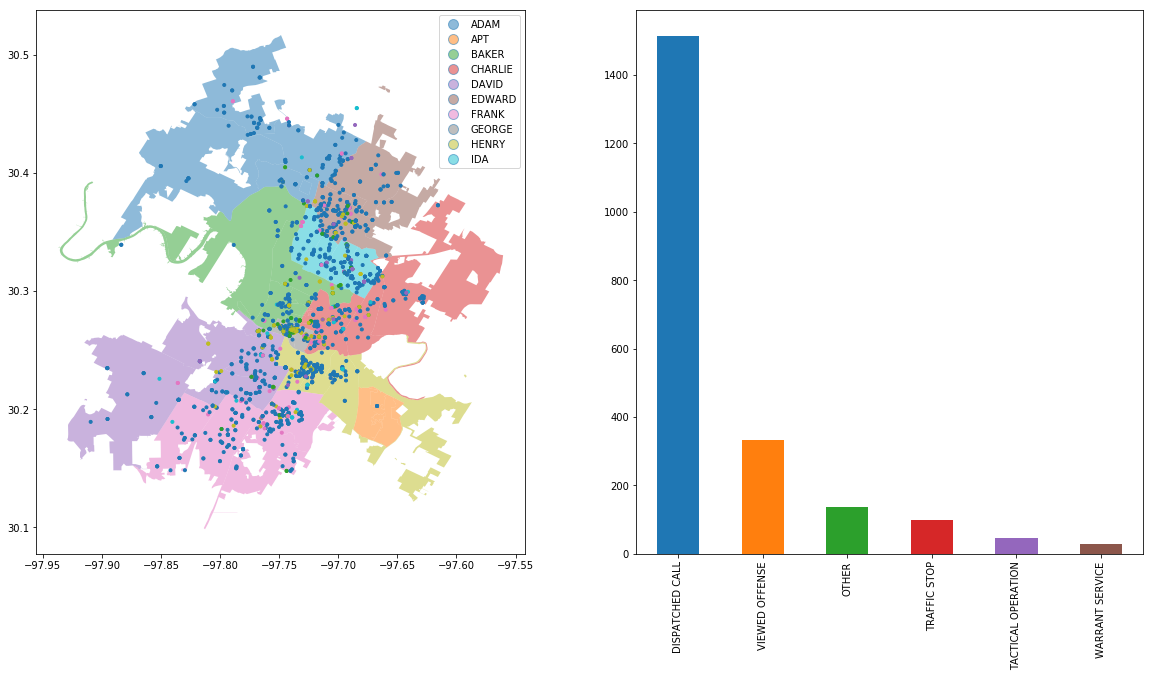

In [9]:
fig1,ax = plt.subplots(1,2,figsize=(20,10))
#fig1.subplots_adjust()
#ax1=plt.subplot(121)
#ax2=plt.subplot(122)
police_shp_gdf.plot(ax=ax[0],column='SECTOR',alpha=0.5,legend=True)
s=police_arrest_gdf['INCIDENT_REASON']
s.value_counts().plot(kind='bar',ax=ax[1])
police_arrest_gdf.plot(marker='.',column="INCIDENT_REASON",ax=ax[0])


GE 
 White       137
Hispanic    122
Black        95
Asian        13
Name: SUBJECT_RACE, dtype: int64


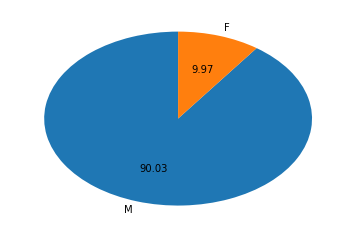

ID 
 Black       110
Hispanic     98
White        77
Asian         1
Name: SUBJECT_RACE, dtype: int64


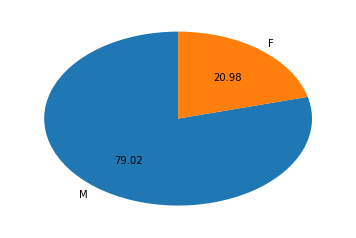

ED 
 Hispanic    126
Black        69
White        62
Asian         5
Name: SUBJECT_RACE, dtype: int64


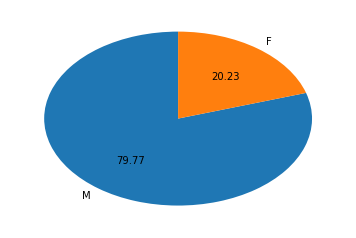

FR 
 Hispanic    156
White        54
Black        32
Name: SUBJECT_RACE, dtype: int64


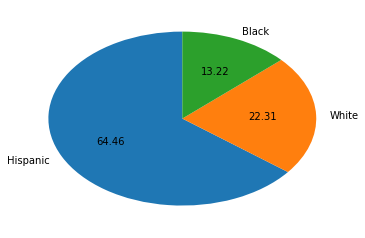

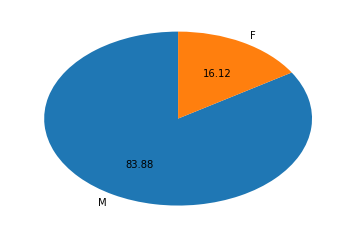

DA 
 White       117
Hispanic     71
Black        41
Asian         1
Name: SUBJECT_RACE, dtype: int64


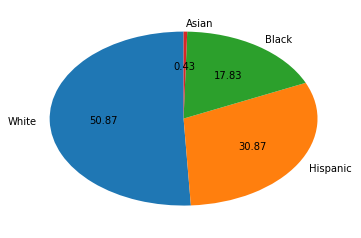

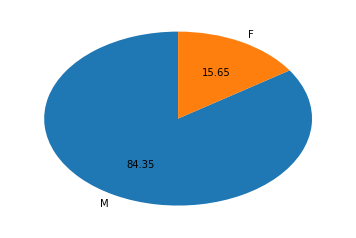

HE 
 Hispanic    90
White       69
Black       66
Asian        1
Name: SUBJECT_RACE, dtype: int64


CH 
 Black       140
Hispanic     59
White        26
Name: SUBJECT_RACE, dtype: int64


BA 
 White       94
Hispanic    27
Black       25
Asian        5
Name: SUBJECT_RACE, dtype: int64


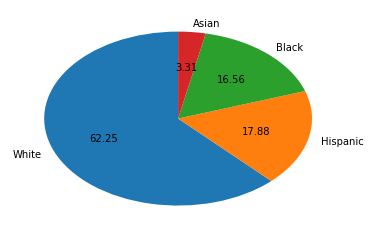

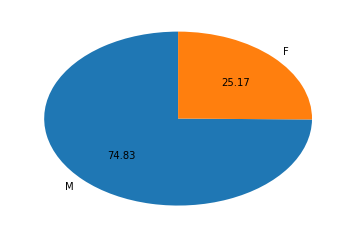

AD 
 White       84
Hispanic    25
Black       22
Asian        1
Name: SUBJECT_RACE, dtype: int64


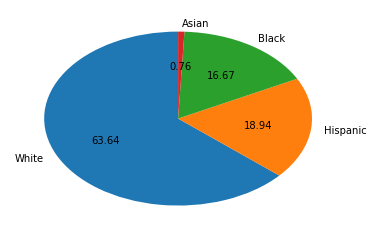

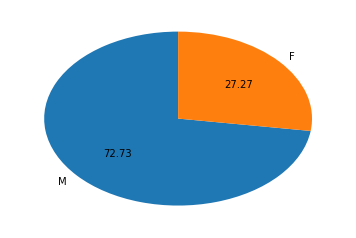

88 
 White    5
Name: SUBJECT_RACE, dtype: int64


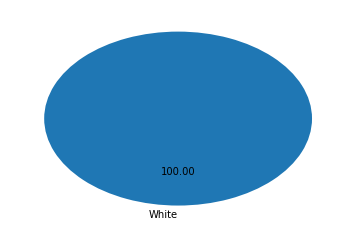

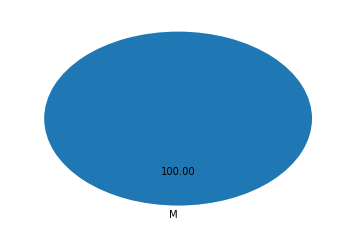

AP 
 Black    3
White    1
Name: SUBJECT_RACE, dtype: int64


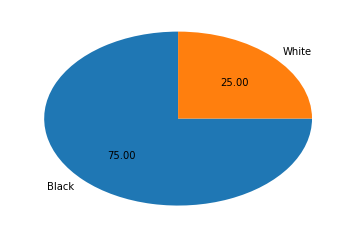

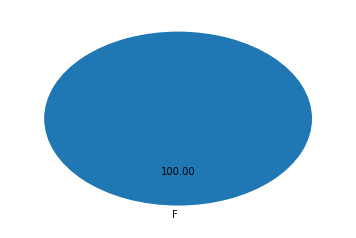

In [11]:
DB_district_list=[k for k in police_arrest_gdf['LOCATION_DISTRICT'].value_counts().keys()]
DB_district_list
def pi_chart(String,gdf):
    conditions = ['LOCATION_DISTRICT',String]
    conditions[1]='"'+ conditions[1] + '"'
    q = " == ".join(conditions)
    DB=gdf
    DB=DB.query(q)
    DB.SUBJECT_RACE.value_counts()
    print(String,'\n',DB.SUBJECT_RACE.value_counts())
    plt.pie(DB.SUBJECT_RACE.value_counts(),labels=DB.SUBJECT_RACE.value_counts().keys(),autopct='%1.2f',startangle=90)
    plt.show()
    plt.pie(DB.SUBJECT_GENDER.value_counts(),labels=DB.SUBJECT_GENDER.value_counts().keys(),autopct='%1.2f',startangle=90)
    plt.show()
for k in DB_district_list:
    pi_chart(k,police_arrest_gdf)

In [12]:
for folder in os.listdir(dept_folder+census_data_folder):
    if 'poverty' in folder:
        poverty_folder = folder
poverty_acs_file_ann,poverty_acs_file_meta = os.listdir(dept_folder+
                                                   census_data_folder+'/'+
                                                   poverty_folder)
# Same idea as above, use pandas for CSV's and geopandas for Shapefiles
census_poverty_df = pd.read_csv(dept_folder+
                             census_data_folder+'/'+
                             poverty_folder+'/'+
                             poverty_acs_file_ann)

census_poverty_df = census_poverty_df.iloc[1:].reset_index(drop=True)
print(dept_folder+
                             census_data_folder+'/'+
                             poverty_folder+'/'+
                             poverty_acs_file_ann)
# Rename Census Tract ID column in ACS Poverty CSV to align with Census Tract Shapefile
census_poverty_df = census_poverty_df.rename(columns={'GEO.id2':'GEOID'})

census_tracts_gdf = gpd.read_file("/Users/apple/Downloads/cb_2017_48_tract_500k/"+
                                  "cb_2017_48_tract_500k.shp")

census_merged_gdf = census_tracts_gdf.merge(census_poverty_df, on = 'GEOID')

census_merged_gdf = census_merged_gdf.to_crs(epsg='4326')

/Users/apple/Downloads/data-science-for-good-2/Dept_37-00027/37-00027_ACS_data/37-00027_ACS_poverty/ACS_15_5YR_S1701_with_ann.csv


In [13]:
census_merged_gdf

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID   NAME LSAD  \
0        48      453  000204  1400000US48453000204  48453000204   2.04   CT   
1        48      453  001000  1400000US48453001000  48453001000     10   CT   
2        48      453  001307  1400000US48453001307  48453001307  13.07   CT   
3        48      453  001504  1400000US48453001504  48453001504  15.04   CT   
4        48      453  001748  1400000US48453001748  48453001748  17.48   CT   
5        48      453  001753  1400000US48453001753  48453001753  17.53   CT   
6        48      453  001776  1400000US48453001776  48453001776  17.76   CT   
7        48      453  001805  1400000US48453001805  48453001805  18.05   CT   
8        48      453  002002  1400000US48453002002  48453002002  20.02   CT   
9        48      453  002005  1400000US48453002005  48453002005  20.05   CT   
10       48      453  002307  1400000US48453002307  48453002307  23.07   CT   
11       48      453  002319  1400000US48453002319  48453002319  23.19   CT   
12       48      453  002413  1400000US48453002413  48453002413  24.13   CT   
13       48      453  002500  1400000US48453002500  48453002500     25   CT   
14       48      453  000203  1400000US48453000203  48453000203   2.03   CT   
15       48      453  000302  1400000US48453000302  48453000302   3.02   CT   
16       48      453  000402  1400000US48453000402  48453000402   4.02   CT   
17       48      453  001604  1400000US48453001604  48453001604  16.04   CT   
18       48      453  001728  1400000US48453001728  48453001728  17.28   CT   
19       48      453  001747  1400000US48453001747  48453001747  17.47   CT   
20       48      453  001752  1400000US48453001752  48453001752  17.52   CT   
21       48      453  001782  1400000US48453001782  48453001782  17.82   CT   
22       48      453  001786  1400000US48453001786  48453001786  17.86   CT   
23       48      453  001824  1400000US48453001824  48453001824  18.24   CT   
24       48      453  001833  1400000US48453001833  48453001833  18.33   CT   
25       48      453  001846  1400000US48453001846  48453001846  18.46   CT   
26       48      453  001861  1400000US48453001861  48453001861  18.61   CT   
27       48      453  001914  1400000US48453001914  48453001914  19.14   CT   
28       48      453  002004  1400000US48453002004  48453002004  20.04   CT   
29       48      453  002106  1400000US48453002106  48453002106  21.06   CT   
..      ...      ...     ...                   ...          ...    ...  ...   
188      48      453  001844  1400000US48453001844  48453001844  18.44   CT   
189      48      453  002426  1400000US48453002426  48453002426  24.26   CT   
190      48      453  002431  1400000US48453002431  48453002431  24.31   CT   
191      48      453  000802  1400000US48453000802  48453000802   8.02   CT   
192      48      453  001402  1400000US48453001402  48453001402  14.02   CT   
193      48      453  001605  1400000US48453001605  48453001605  16.05   CT   
194      48      453  001765  1400000US48453001765  48453001765  17.65   CT   
195      48      453  001785  1400000US48453001785  48453001785  17.85   CT   
196      48      453  001826  1400000US48453001826  48453001826  18.26   CT   
197      48      453  001855  1400000US48453001855  48453001855  18.55   CT   
198      48      453  001913  1400000US48453001913  48453001913  19.13   CT   
199      48      453  002411  1400000US48453002411  48453002411  24.11   CT   
200      48      453  002427  1400000US48453002427  48453002427  24.27   CT   
201      48      453  001749  1400000US48453001749  48453001749  17.49   CT   
202      48      453  001777  1400000US48453001777  48453001777  17.77   CT   
203      48      453  001821  1400000US48453001821  48453001821  18.21   CT   
204      48      453  001840  1400000US48453001840  48453001840  18.40   CT   
205      48      453  001850  1400000US48453001850  48453001850  18.50   CT   
206      48      453  001915  1400000US48453001915  48

In [14]:
census_merged_gdf['DISTRICT']='N/A'

In [15]:

for index1, x in police_shp_gdf.iterrows():
    for index2, y in census_merged_gdf.iterrows():
          if y['DISTRICT']=='N/A' and x['geometry'].contains(y['geometry']):
                census_merged_gdf.at[index2,'DISTRICT']=x['SECTOR']


In [16]:
census_merged_gdf['geometry']##police_shp_gdf['geometry']

0      POLYGON ((-97.74882099999999 30.304717, -97.74...
1      POLYGON ((-97.737174 30.259136, -97.736553 30....
2      POLYGON ((-97.77566 30.230012, -97.774424 30.2...
3      POLYGON ((-97.736611 30.346735, -97.7357799999...
4      POLYGON ((-97.857782 30.171094, -97.856437 30....
5      POLYGON ((-97.74601700000001 30.400407, -97.74...
6      POLYGON ((-97.85095199999999 30.213985, -97.84...
7      POLYGON ((-97.71782999999999 30.365565, -97.71...
8      POLYGON ((-97.79099100000001 30.225755, -97.78...
9      POLYGON ((-97.788341 30.229902, -97.7857810000...
10     POLYGON ((-97.747455 30.223299, -97.745333 30....
11     POLYGON ((-97.65017399999999 30.198271, -97.64...
12     POLYGON ((-97.745015 30.189752, -97.744621 30....
13     POLYGON ((-97.767528 30.412249, -97.763475 30....
14     POLYGON ((-97.74003900000001 30.30995, -97.737...
15     POLYGON ((-97.73579599999999 30.30639, -97.732...
16     POLYGON ((-97.72899000000001 30.28065399999999...
17     POLYGON ((-97.785921 30.

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID   NAME LSAD  \
0        48      453  000204  1400000US48453000204  48453000204   2.04   CT   
1        48      453  001000  1400000US48453001000  48453001000     10   CT   
2        48      453  001307  1400000US48453001307  48453001307  13.07   CT   
3        48      453  001504  1400000US48453001504  48453001504  15.04   CT   
4        48      453  001748  1400000US48453001748  48453001748  17.48   CT   
5        48      453  001753  1400000US48453001753  48453001753  17.53   CT   
6        48      453  001776  1400000US48453001776  48453001776  17.76   CT   
7        48      453  001805  1400000US48453001805  48453001805  18.05   CT   
8        48      453  002002  1400000US48453002002  48453002002  20.02   CT   
9        48      453  002005  1400000US48453002005  48453002005  20.05   CT   
10       48      453  002307  1400000US48453002307  48453002307  23.07   CT   
11       48      453  002319  1400000US48453002319  48453002319  23.19   CT   
12       48      453  002413  1400000US48453002413  48453002413  24.13   CT   
13       48      453  002500  1400000US48453002500  48453002500     25   CT   
14       48      453  000203  1400000US48453000203  48453000203   2.03   CT   
15       48      453  000302  1400000US48453000302  48453000302   3.02   CT   
16       48      453  000402  1400000US48453000402  48453000402   4.02   CT   
17       48      453  001604  1400000US48453001604  48453001604  16.04   CT   
18       48      453  001728  1400000US48453001728  48453001728  17.28   CT   
19       48      453  001747  1400000US48453001747  48453001747  17.47   CT   
20       48      453  001752  1400000US48453001752  48453001752  17.52   CT   
21       48      453  001782  1400000US48453001782  48453001782  17.82   CT   
22       48      453  001786  1400000US48453001786  48453001786  17.86   CT   
23       48      453  001824  1400000US48453001824  48453001824  18.24   CT   
24       48      453  001833  1400000US48453001833  48453001833  18.33   CT   
25       48      453  001846  1400000US48453001846  48453001846  18.46   CT   
26       48      453  001861  1400000US48453001861  48453001861  18.61   CT   
27       48      453  001914  1400000US48453001914  48453001914  19.14   CT   
28       48      453  002004  1400000US48453002004  48453002004  20.04   CT   
29       48      453  002106  1400000US48453002106  48453002106  21.06   CT   
..      ...      ...     ...                   ...          ...    ...  ...   
188      48      453  001844  1400000US48453001844  48453001844  18.44   CT   
189      48      453  002426  1400000US48453002426  48453002426  24.26   CT   
190      48      453  002431  1400000US48453002431  48453002431  24.31   CT   
191      48      453  000802  1400000US48453000802  48453000802   8.02   CT   
192      48      453  001402  1400000US48453001402  48453001402  14.02   CT   
193      48      453  001605  1400000US48453001605  48453001605  16.05   CT   
194      48      453  001765  1400000US48453001765  48453001765  17.65   CT   
195      48      453  001785  1400000US48453001785  48453001785  17.85   CT   
196      48      453  001826  1400000US48453001826  48453001826  18.26   CT   
197      48      453  001855  1400000US48453001855  48453001855  18.55   CT   
198      48      453  001913  1400000US48453001913  48453001913  19.13   CT   
199      48      453  002411  1400000US48453002411  48453002411  24.11   CT   
200      48      453  002427  1400000US48453002427  48453002427  24.27   CT   
201      48      453  001749  1400000US48453001749  48453001749  17.49   CT   
202      48      453  001777  1400000US48453001777  48453001777  17.77   CT   
203      48      453  001821  1400000US48453001821  48453001821  18.21   CT   
204      48      453  001840  1400000US48453001840  48453001840  18.40   CT   
205      48      453  001850  1400000US48453001850  48453001850  18.50   CT   
206      48      453  001915  1400000US48453001915  48

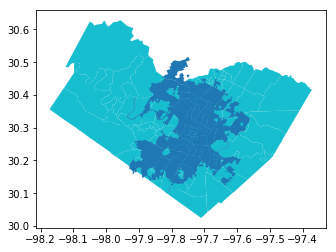

In [47]:
fig2,ax2 = plt.subplots()
census_merged_gdf.plot(ax=ax2,column='DISTRICT')
police_shp_gdf.plot(ax=ax2)

In [48]:
police_shp_gdf

NAME  SORTORDER  BATID  JURIID       COLOR  CODE EXTERNALKE  \
0       CHARLIE 4        1.0  400.0    11.0  16744576.0  1282       1282   
1        GEORGE 1        1.0  194.0    15.0  16744576.0  1298       1298   
2        GEORGE 2        1.0  194.0    15.0  16776960.0  1297       1297   
3           IDA 1        1.0  215.0    60.0  16744576.0  1307       1307   
4           IDA 2        1.0  215.0    60.0  16711680.0  1304       1304   
5           IDA 3        1.0  215.0    60.0  16711808.0  1306       1306   
6           IDA 4        1.0  215.0    60.0  16711808.0  1305       1305   
7        EDWARD 3        1.0  174.0    13.0  16711680.0  1290       1290   
8        EDWARD 1        1.0  174.0    13.0  16711680.0  1288       1288   
9        GEORGE 3        1.0  194.0    15.0  16776960.0  1299       1299   
10       GEORGE 4        1.0  194.0    15.0  16776960.0  1296       1296   
11        BAKER 3        1.0  144.0    10.0  16711808.0  1277       1277   
12         ADAM 2        1.0   21.0     6.0  16744448.0  1273       1273   
13         ADAM 4        1.0   21.0     6.0  16744448.0  1272       1272   
14         ADAM 1        1.0   21.0     6.0  16744448.0  1270       1270   
15        BAKER 1        1.0  144.0    10.0  16711808.0  1275       1275   
16        DAVID 2        1.0  164.0    12.0  16711680.0  1284       1284   
17        DAVID 1        1.0  164.0    12.0  16711808.0  1283       1283   
18        HENRY 1        1.0  205.0    59.0  16711808.0  1301       1301   
19        DAVID 3        1.0  164.0    12.0  16711680.0  1285       1285   
20        FRANK 2        1.0  184.0    14.0  16744448.0  1293       1293   
21       EDWARD 2        1.0  174.0    13.0  16711680.0  1289       1289   
22      CHARLIE 3        1.0  400.0    11.0  16744576.0  1281       1281   
23      CHARLIE 1        1.0  400.0    11.0  16744576.0  1279       1279   
24        BAKER 4        1.0  144.0    10.0  16711808.0  1276       1276   
25         ADAM 3        1.0   21.0     6.0  16744448.0  1271       1271   
26        HENRY 2        1.0  205.0    59.0  16711808.0  1300       1300   
27        FRANK 1        1.0  184.0    14.0  16744448.0  1292       1292   
28        FRANK 3        1.0  184.0    14.0  16744448.0  1295       1295   
29        FRANK 4        1.0  184.0    14.0  16744448.0  1294       1294   
30      CHARLIE 2        1.0  400.0    11.0  16744576.0  1280       1280   
31          A1 UT        0.0  307.0   121.0   6855915.0  1308       1308   
32          B4 UT        0.0  307.0   121.0    556569.0  1309       1309   
33  DAVID PARK PD        1.0  164.0    12.0     32768.0  1287       1287   
34        B1 UT-2        0.0  307.0   121.0  11770334.0  1310       1310   
35        C3 UT-3        0.0  307.0   121.0   4963824.0  1312       1312   
36        C3 UT-2        0.0  307.0   121.0   9531876.0  1313       1313   
37        B1 UT-1        0.0  307.0   121.0   6490719.0  1311       1311   
38        HENRY 3        1.0  205.0    59.0  16711808.0  1302       1302   
39            AOA        0.0  520.0   145.0  16776960.0  1336       1336   
40        C3 UT-1        0.0  307.0   121.0   2665254.0  1314       1314   
41  BAKER PARK PD        0.0  144.0    10.0     32768.0  1278       1278   
42        HENRY 4        1.0  205.0    59.0  16711808.0  1303       1303   
43        DAVID 4        1.0  164.0    12.0  16711680.0  1286       1286   
44       EDWARD 4        1.0  174.0    13.0  16711680.0  1291       1291   
45         PUBLIC        0.0  520.0   145.0  16776960.0  1337       1337   
46            STS        0.0  519.0   145.0  16776960.0  1334       1334   
47            STP        0.0  519.0   145.0  16776960.0  1335       1335   
48            MTS        0.0  517.0   145.0  16776960.0  1331       1331   
49            MTP        0.0  517.0   145.0  16776960.0  1332       1332   
50            LND        0.0  518.0   145.0  16776960.0  1333       1333   
51            LND        0.0  518.0   145.0  16776960.0  1333

In [81]:
police_arrest_gdf['GEOid']=0
police_arrest_gdf['SECTOR']='N/A'
for index1, x in census_merged_gdf.iterrows():
    for index2, y in police_arrest_gdf.iterrows():
        if y['GEOid']==0 and x['geometry'].contains(y['geometry']):
                police_arrest_gdf.at[index2,'GEOid']=x['GEOID']
                police_arrest_gdf.at[index2,'SECTOR']=x['DISTRICT']
            

In [82]:
police_arrest_gdf

RIN  PRIMARY_KEY INCIDENT_DATE LOCATION_DISTRICT     INCIDENT_REASON  \
0     143002   2014170002     1/17/2014                GE               OTHER   
1     149691  20141981994     7/18/2014                FR     DISPATCHED CALL   
2     153115  20143060391     11/2/2014                GE      VIEWED OFFENSE   
3     149599  20141931963     7/12/2014                CH      VIEWED OFFENSE   
4     152713  20142921903    10/20/2014                AD     DISPATCHED CALL   
5     152690  20142921903    10/20/2014                AD     DISPATCHED CALL   
6     145088  20145012665     3/21/2014                GE               OTHER   
7     149701  20142030006     7/22/2014                ID     DISPATCHED CALL   
8     152946  20142972378    10/24/2014                GE     DISPATCHED CALL   
9     145528   2014870017     3/28/2014                ED     DISPATCHED CALL   
10    144369   2014560006     2/25/2014                ID     DISPATCHED CALL   
11    151503  20142490002      9/6/2014                ID               OTHER   
12    154519  20143600051    12/26/2014                GE     DISPATCHED CALL   
13    152441  20142770147     10/4/2014                GE      VIEWED OFFENSE   
14    144068   2014400178      2/9/2014                GE     DISPATCHED CALL   
15    146866  20141280639      5/8/2014                ID      VIEWED OFFENSE   
16    146108  20141030129     4/13/2014                CH     DISPATCHED CALL   
17    146700  20141201816     4/30/2014                ID               OTHER   
18    152120  20142640757     9/21/2014                CH     DISPATCHED CALL   
19    152540  20142810641     10/8/2014                BA     DISPATCHED CALL   
20    150441  20142240271     8/12/2014                ID      VIEWED OFFENSE   
21    145651   2014820047     3/23/2014                GE               OTHER   
22    145959   2014950110      4/5/2014                DA     DISPATCHED CALL   
23    145448   2014771839     2/18/2014                DA     DISPATCHED CALL   
24    144371   2014630048      3/4/2014                DA     DISPATCHED CALL   
25    144374   2014630048      3/4/2014                DA     DISPATCHED CALL   
26    144389   2014630048      3/4/2014                DA     DISPATCHED CALL   
27    149779  20142040052     7/23/2014                FR     DISPATCHED CALL   
28    144828   2014740180     3/15/2014                GE      VIEWED OFFENSE   
29    141988    201410352      1/1/2014                AD     DISPATCHED CALL   
...      ...          ...           ...               ...                 ...   
2130  149739  20141611986     6/11/2014                DA     DISPATCHED CALL   
2131  149742  20141901753      7/9/2014                DA               OTHER   
2132  152744  20142840749    10/11/2014                DA     DISPATCHED CALL   
2133  153728  20143251834    11/22/2014                BA      VIEWED OFFENSE   
2134  151839  20142520799      9/9/2014                AD     DISPATCHED CALL   
2135  146002  20145004585      4/9/2014                HE  TACTICAL OPERATION   
2136  144188   2014500826     2/19/2014                CH        TRAFFIC STOP   
2137  150462  20142231458     8/11/2014                DA               OTHER   
2138  150537  20142261044     8/14/2014                ED     DISPATCHED CALL   
2139  145961   2014971612      4/7/2014                BA     DISPATCHED CALL   
2140  145160   2014811608     3/22/2014                GE               OTHER   
2141  153763  20143271479    11/23/2014                DA     DISPATCHED CALL   
2142  154799  20143160687    11/12/2014                GE      VIEWED OFFENSE   
2143  146285  20146900284     4/19/2014                GE               OTHER   
2144  145848   2014890495     3/30/2014                DA     DISPATCHED CALL   
2145  150603  20142291747     8/17/2014                ID     DISPATCHED CALL   
2146  144728   2014700318     3/11/2014                FR     DISPATCHED CALL   
2147  150123  20142121357     7/31/2014 

In [110]:
police_arrest_gdf = police_arrest_gdf[(police_arrest_gdf['SUBJECT_ROLE'] == 'ARRESTED' )| (police_arrest_gdf['SUBJECT_ROLE'] == 'JUV-ARRESTE')| 
                    (police_arrest_gdf['SUBJECT_ROLE'] == 'COMMITTED') |
                    (police_arrest_gdf['SUBJECT_ROLE'] == 'SUSPECT')|
                    (police_arrest_gdf['SUBJECT_ROLE'] == 'INVOLVED')|
                   ( police_arrest_gdf['SUBJECT_ROLE'] == 'JUV-SUBJECT')|
                    (police_arrest_gdf['SUBJECT_ROLE'] == 'SUMMONS/CIT')]
                    

In [109]:
new_arrest

RIN  PRIMARY_KEY INCIDENT_DATE LOCATION_DISTRICT     INCIDENT_REASON  \
0     143002   2014170002     1/17/2014                GE               OTHER   
1     149691  20141981994     7/18/2014                FR     DISPATCHED CALL   
2     153115  20143060391     11/2/2014                GE      VIEWED OFFENSE   
4     152713  20142921903    10/20/2014                AD     DISPATCHED CALL   
5     152690  20142921903    10/20/2014                AD     DISPATCHED CALL   
7     149701  20142030006     7/22/2014                ID     DISPATCHED CALL   
8     152946  20142972378    10/24/2014                GE     DISPATCHED CALL   
11    151503  20142490002      9/6/2014                ID               OTHER   
12    154519  20143600051    12/26/2014                GE     DISPATCHED CALL   
13    152441  20142770147     10/4/2014                GE      VIEWED OFFENSE   
14    144068   2014400178      2/9/2014                GE     DISPATCHED CALL   
15    146866  20141280639      5/8/2014                ID      VIEWED OFFENSE   
16    146108  20141030129     4/13/2014                CH     DISPATCHED CALL   
17    146700  20141201816     4/30/2014                ID               OTHER   
18    152120  20142640757     9/21/2014                CH     DISPATCHED CALL   
19    152540  20142810641     10/8/2014                BA     DISPATCHED CALL   
20    150441  20142240271     8/12/2014                ID      VIEWED OFFENSE   
21    145651   2014820047     3/23/2014                GE               OTHER   
22    145959   2014950110      4/5/2014                DA     DISPATCHED CALL   
23    145448   2014771839     2/18/2014                DA     DISPATCHED CALL   
24    144371   2014630048      3/4/2014                DA     DISPATCHED CALL   
25    144374   2014630048      3/4/2014                DA     DISPATCHED CALL   
26    144389   2014630048      3/4/2014                DA     DISPATCHED CALL   
27    149779  20142040052     7/23/2014                FR     DISPATCHED CALL   
28    144828   2014740180     3/15/2014                GE      VIEWED OFFENSE   
30    154102  20143470130    12/13/2014                GE     DISPATCHED CALL   
32    149274  20141852648      7/4/2014                ID     DISPATCHED CALL   
33    144893   2014760078     3/17/2014                GE      VIEWED OFFENSE   
34    144818   2014760078     3/17/2014                GE      VIEWED OFFENSE   
41    146043  20141000081     4/10/2014                DA     DISPATCHED CALL   
...      ...          ...           ...               ...                 ...   
2125  144428   2014620087      3/3/2014                GE      VIEWED OFFENSE   
2126  153280  20143081175     11/4/2014                ED     DISPATCHED CALL   
2127  152339  20142731893     9/30/2014                ID               OTHER   
2128  152585  20142841619    10/11/2014                DA      VIEWED OFFENSE   
2129  147000  20141321233     5/12/2014                AD     DISPATCHED CALL   
2130  149739  20141611986     6/11/2014                DA     DISPATCHED CALL   
2131  149742  20141901753      7/9/2014                DA               OTHER   
2132  152744  20142840749    10/11/2014                DA     DISPATCHED CALL   
2133  153728  20143251834    11/22/2014                BA      VIEWED OFFENSE   
2134  151839  20142520799      9/9/2014                AD     DISPATCHED CALL   
2135  146002  20145004585      4/9/2014                HE  TACTICAL OPERATION   
2136  144188   2014500826     2/19/2014                CH        TRAFFIC STOP   
2137  150462  20142231458     8/11/2014                DA               OTHER   
2139  145961   2014971612      4/7/2014                BA     DISPATCHED CALL   
2140  145160   2014811608     3/22/2014                GE               OTHER   
2141  153763  20143271479    11/23/2014                DA     DISPATCHED CALL   
2142  154799  20143160687    11/12/2014                GE      VIEWED OFFENSE   
2143  146285  20146900284     4/19/2014 

In [111]:
police_arrest_gdf['INCIDENT_REASON'].value_counts()
police_arrest_gdf['SUBJECT_ROLE'].value_counts()

ARRESTED       1513
JUV-ARRESTE     137
COMMITTED       117
SUSPECT          74
INVOLVED         31
JUV-SUBJECT      13
SUMMONS/CIT       3
Name: SUBJECT_ROLE, dtype: int64

In [51]:
DB_district_list

['GE', 'ID', 'ED', 'FR', 'DA', 'HE', 'CH', 'BA', 'AD', '88', 'AP']

In [52]:
MMIindex=pd.read_csv('/Users/apple/Downloads/racism_index/summary_table.csv')
MMIindex['LOCATION_DISTRICT']='N/A'

In [53]:
len(MMIindex['LOCATION_DISTRICT'])

218

In [112]:
def find_District(Name,police_arrest_gdf):
    tracts=[]
    for index, row in police_arrest_gdf.iterrows():
        if row['LOCATION_DISTRICT']==Name:
            tracts.append(row['GEOid'])
    return set(tracts)

In [113]:
Dist_map_list={}
for item in DB_district_list:
    Dist_map_list[item]=find_District(item,police_arrest_gdf)
    

In [114]:
for item in DB_district_list:
    for i, row in MMIindex.iterrows():
            if row['GEO.id2'] in Dist_map_list[item] and row['LOCATION_DISTRICT']=='N/A':
                MMIindex.at[i,'LOCATION_DISTRICT']=item

In [115]:
48453000901 in Dist_map_list['GE']

True

In [116]:
MMIindex['Arrest']=0

In [117]:
p=0
for k, row1  in police_arrest_gdf.iterrows():
    for i, row  in MMIindex.iterrows():
        if row1['GEOid'] == row['GEO.id2']:
                MMIindex.at[i,'Arrest']=MMIindex.at[i,'Arrest']+1


1857


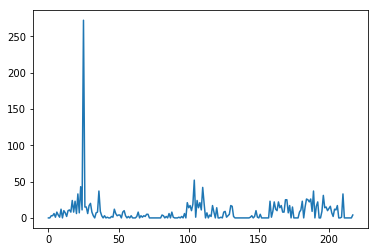

In [118]:
MMIindex['Arrest'].plot()
print(MMIindex['Arrest'].sum())

In [123]:
MMIindex.to_csv('/Users/apple/PycharmProjects/untitled1/summary_with_arrest.csv')